## Data Description
**Sample Dataset: World University Rankings 2024**
#### Source: https://www.timeshighereducation.com/world-university-rankings
#### Last Updated: January 2024
### **Synopsis:**
The dataset provides a list of the top-ranked universities in the world along with indicators like international outlook, teaching score, research score, industry income, and overall rank. It helps in analyzing global education trends and institutional performance.




Joined Data (Universities + Scores):
                      name      country  world_rank  research_score  \
0     University of Oxford           UK           1            98.8   
1      Stanford University          USA           2            97.9   
2       Harvard University          USA           3            97.1   
3               ETH Zurich  Switzerland           9            92.5   
4      Tsinghua University        China          12            91.3   
5  University of Melbourne    Australia          34            88.1   

   teaching_score  international_score  industry_income  
0            96.5                 94.3             89.7  
1            95.2                 92.0             87.1  
2            93.7                 90.8             85.4  
3            91.2                 89.9             86.3  
4            90.3                 88.5             84.2  
5            89.2                 86.7             82.4  

Top 3 Universities by Teaching Score:
                   

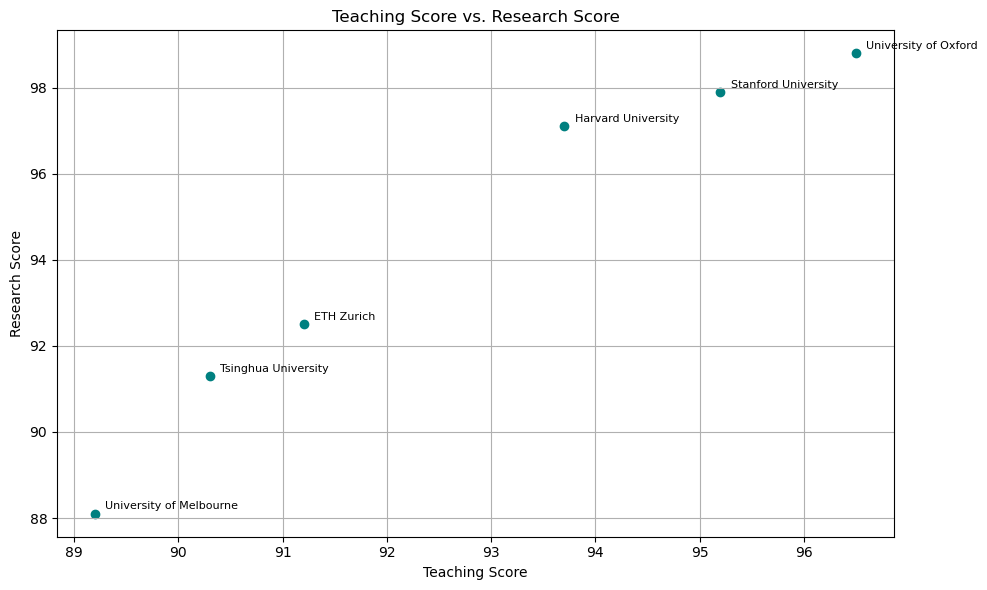

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# 1. Creating Database and Tables
# --------------------------
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Universities Table
cursor.execute('''
CREATE TABLE universities (
    uni_id INTEGER PRIMARY KEY,
    name TEXT,
    country TEXT,
    world_rank INTEGER,
    research_score REAL
)
''')

# Scores Table
cursor.execute('''
CREATE TABLE scores (
    score_id INTEGER PRIMARY KEY,
    uni_id INTEGER,
    teaching_score REAL,
    international_score REAL,
    industry_income REAL,
    FOREIGN KEY (uni_id) REFERENCES universities(uni_id)
)
''')

# --------------------------
# 2. Inserting Sample Data
# --------------------------
universities_data = [
    (1, 'University of Oxford', 'UK', 1, 98.8),
    (2, 'Stanford University', 'USA', 2, 97.9),
    (3, 'Harvard University', 'USA', 3, 97.1),
    (4, 'ETH Zurich', 'Switzerland', 9, 92.5),
    (5, 'Tsinghua University', 'China', 12, 91.3),
    (6, None, 'Germany', 25, None),  # Row with NULL values
]

scores_data = [
    (1, 1, 96.5, 94.3, 89.7),
    (2, 2, 95.2, 92.0, 87.1),
    (3, 3, 93.7, 90.8, 85.4),
    (4, 4, 91.2, 89.9, 86.3),
    (5, 5, 90.3, 88.5, 84.2),
    (6, 6, None, None, None),  # Row with NULL values
]

cursor.executemany("INSERT INTO universities VALUES (?, ?, ?, ?, ?)", universities_data)
cursor.executemany("INSERT INTO scores VALUES (?, ?, ?, ?, ?)", scores_data)
conn.commit()

# --------------------------
# 3. Remove NULL Records
# --------------------------
cursor.execute("DELETE FROM universities WHERE name IS NULL OR research_score IS NULL")
cursor.execute("DELETE FROM scores WHERE teaching_score IS NULL")
conn.commit()

# --------------------------
# 4. Add a New Row
# --------------------------
cursor.execute('''
INSERT INTO universities (uni_id, name, country, world_rank, research_score)
VALUES (7, 'University of Melbourne', 'Australia', 34, 88.1)
''')
cursor.execute('''
INSERT INTO scores (score_id, uni_id, teaching_score, international_score, industry_income)
VALUES (7, 7, 89.2, 86.7, 82.4)
''')
conn.commit()

# --------------------------
# 5. JOIN Tables and Display
# --------------------------
print("\nJoined Data (Universities + Scores):")
joined_df = pd.read_sql_query('''
SELECT u.name, u.country, u.world_rank, u.research_score,
       s.teaching_score, s.international_score, s.industry_income
FROM universities u
JOIN scores s ON u.uni_id = s.uni_id
ORDER BY u.world_rank ASC
''', conn)
print(joined_df)

# --------------------------
# 6. Queries
# --------------------------

# Query 1: Top 3 Universities by Teaching Score
print("\nTop 3 Universities by Teaching Score:")
top_teaching = pd.read_sql_query('''
SELECT name, teaching_score FROM universities u
JOIN scores s ON u.uni_id = s.uni_id
ORDER BY teaching_score DESC
LIMIT 3
''', conn)
print(top_teaching)

# Query 2: Average Research Score by Country
print("\nAverage Research Score by Country:")
avg_research = pd.read_sql_query('''
SELECT country, AVG(research_score) as avg_research
FROM universities
GROUP BY country
''', conn)
print(avg_research)

# --------------------------
# 7. Visualization: Teaching Score vs. Research Score
# --------------------------
plt.figure(figsize=(10, 6))
plt.scatter(joined_df['teaching_score'], joined_df['research_score'], color='teal')
for i, name in enumerate(joined_df['name']):
    plt.text(joined_df['teaching_score'][i]+0.1, joined_df['research_score'][i]+0.1, name, fontsize=8)
plt.title('Teaching Score vs. Research Score')
plt.xlabel('Teaching Score')
plt.ylabel('Research Score')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close the connection
conn.close()
